In [1]:
import torch
import torch.nn.functional as F
from torch.distributions.normal import Normal
from datasets import load_dataset
import os
from transformer_lens import utils, HookedTransformer
from datasets.arrow_dataset import Dataset
from sae_vis.model_fns import AutoEncoder, AutoEncoderConfig
from sae_vis.data_storing_fns import SaeVisData
from sae_vis.data_config_classes import SaeVisConfig
import matplotlib.pyplot as plt

from main import SparseAutoencoder, input_dim, expansion_factor, tokenizer, hook_point, model

torch.set_grad_enabled(False);

/Users/joel/code/sae_expected_l0/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/joel/code/sae_expected_l0/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/Users/joel/code/sae_expected_l0/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. 

Loaded pretrained model roneneldan/TinyStories-1M into HookedTransformer


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [2]:
state_dict = torch.load("/Users/joel/code/sae_expected_l0/uo0dzeuj-files/brisk-sweep-8_sae.pth", map_location=torch.device('cpu'))

In [3]:
reconstruction_coefficient = 139121.40320313442
stddev_prior = 0.019314321518165953
normal = Normal(0, 1)

In [4]:
sae = SparseAutoencoder(input_dim=input_dim, hidden_dim=input_dim*expansion_factor, stddev_prior=stddev_prior)
sae.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:
tokens = tokenizer("Hello, world! This is just some filler text used to estimate stddev.")["input_ids"]
output, cache = model.run_with_cache(
    torch.tensor(tokens, device="cpu"), remove_batch_dim=True
)
x = cache[hook_point]

In [6]:
x.shape

torch.Size([17, 64])

In [7]:
torch.std(x, dim=0, unbiased=True)

tensor([0.0179, 0.0139, 0.0171, 0.0163, 0.0190, 0.0221, 0.0211, 0.0284, 0.0193,
        0.0175, 0.0150, 0.0139, 0.0198, 0.0084, 0.0183, 0.0158, 0.0188, 0.0213,
        0.0330, 0.0202, 0.0327, 0.0240, 0.0158, 0.0167, 0.0183, 0.0198, 0.0266,
        0.0220, 0.0183, 0.0216, 0.0162, 0.0149, 0.0105, 0.0171, 0.0149, 0.0204,
        0.0147, 0.0166, 0.0177, 0.0114, 0.0260, 0.0286, 0.0228, 0.0188, 0.0233,
        0.0144, 0.0150, 0.0168, 0.0280, 0.0203, 0.0173, 0.0100, 0.0243, 0.0209,
        0.0130, 0.0240, 0.0210, 0.0173, 0.0128, 0.0145, 0.0262, 0.0185, 0.0280,
        0.0202])

In [8]:
sae.stddev_prior

0.019314321518165953

In [9]:
torch.std(x, dim=0, unbiased=True).mean()

tensor(0.0192)

In [10]:
stddevs = sae.stddev_prior * torch.sqrt((sae.encoder.weight**2).sum(dim=1))

In [11]:
x_hat, pre_activation = sae(x)

In [12]:
pre_activation

tensor([[-0.0723, -0.0606, -0.0587,  ..., -0.0694, -0.0624, -0.1285],
        [-0.0720, -0.0611, -0.0683,  ..., -0.0761, -0.0545, -0.1355],
        [-0.0524, -0.0681, -0.0644,  ..., -0.0680, -0.0732, -0.1306],
        ...,
        [-0.0645, -0.0830, -0.0586,  ..., -0.0707, -0.0863, -0.1344],
        [-0.0745, -0.0759, -0.0610,  ..., -0.0642, -0.0792, -0.1261],
        [-0.0703, -0.0655, -0.0730,  ..., -0.0859, -0.0599, -0.1267]])

In [13]:
-pre_activation / stddevs

tensor([[10.4832,  8.6007,  8.7652,  ..., 10.3443, 10.2058, 18.5127],
        [10.4429,  8.6603, 10.2004,  ..., 11.3373,  8.9161, 19.5177],
        [ 7.6013,  9.6651,  9.6139,  ..., 10.1214, 11.9755, 18.8107],
        ...,
        [ 9.3536, 11.7698,  8.7433,  ..., 10.5363, 14.1203, 19.3537],
        [10.8045, 10.7722,  9.1128,  ...,  9.5684, 12.9630, 18.1636],
        [10.1865,  9.2877, 10.8984,  ..., 12.7874,  9.7985, 18.2511]])

In [14]:
prob_non_zero = 1 - normal.cdf(-pre_activation / stddevs * 0.5)

In [15]:
prob_non_zero[:5, :5]

tensor([[1.1921e-07, 8.5235e-06, 5.8413e-06, 0.0000e+00, 0.0000e+00],
        [1.1921e-07, 7.4506e-06, 1.7881e-07, 0.0000e+00, 0.0000e+00],
        [7.2122e-05, 7.1526e-07, 7.7486e-07, 0.0000e+00, 3.0398e-06],
        [7.1526e-07, 2.3842e-07, 2.3842e-07, 0.0000e+00, 0.0000e+00],
        [2.3842e-07, 6.4969e-06, 4.9710e-05, 0.0000e+00, 1.1921e-07]])

In [16]:
def histogram(arr, title=''):
    plt.hist(arr.flatten().cpu().detach().numpy(), bins=50, alpha=0.75, color='blue')
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

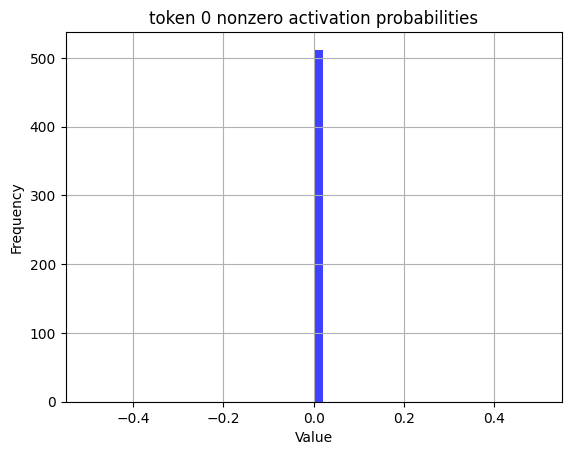

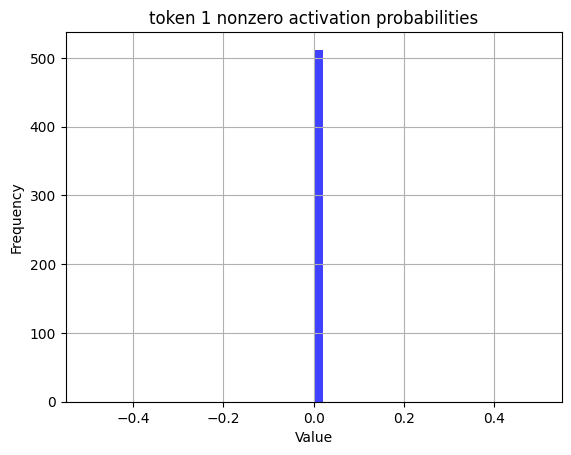

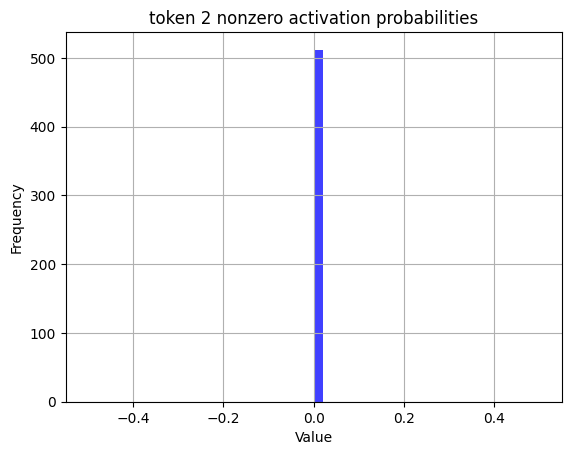

In [17]:
def token_non_zero_hist(i):
    x_hat, pre_activation = sae(x[i])
    stddevs = stddev_prior * torch.sqrt((sae.encoder.weight**2).sum(dim=1))
    prob_non_zero = 1 - normal.cdf(-pre_activation / stddevs)
    histogram(prob_non_zero, f"token {i} nonzero activation probabilities")

for i in range(3):
    token_non_zero_hist(i)

In [18]:
sae.encoder.bias.mean()

tensor(-0.0764)

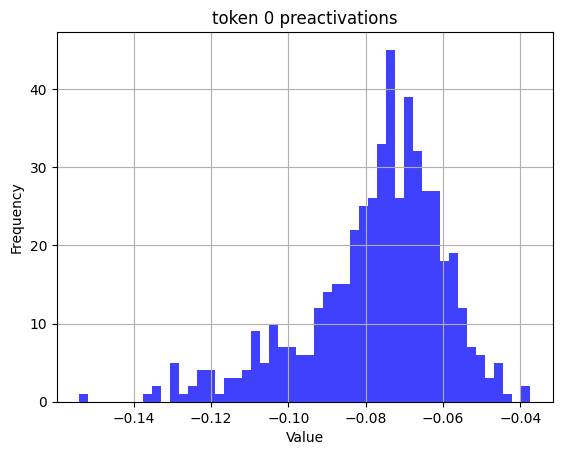

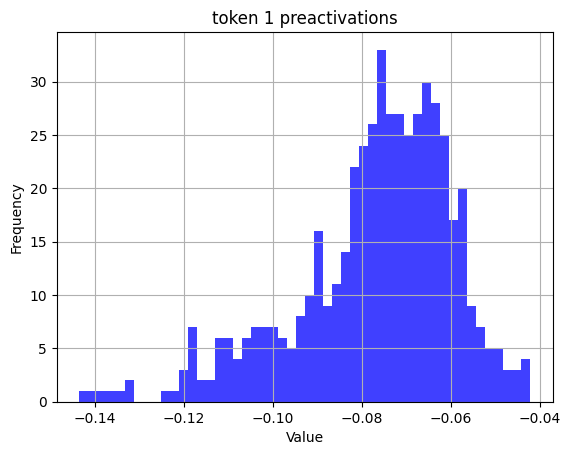

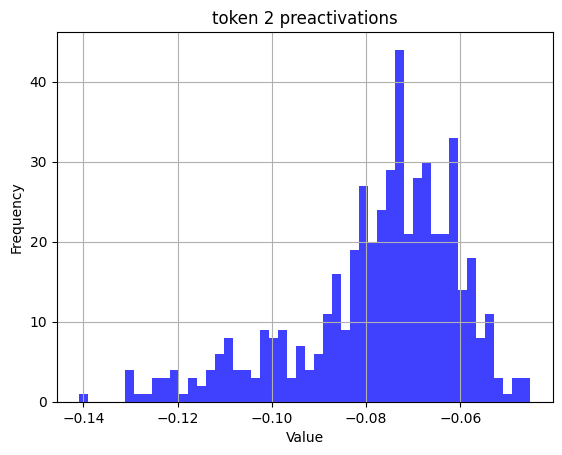

In [19]:
def token_non_zero_hist(i):
    pre = sae.encoder(x[i])
    histogram(pre, f"token {i} preactivations")

for i in range(3):
    token_non_zero_hist(i)

In [20]:
x_hat, pre_activation = sae(x)
reconstruction_loss = F.mse_loss(x_hat, x)
l0_loss = sae.expected_l0_loss(pre_activation)
loss = reconstruction_coefficient * reconstruction_loss + l0_loss
print(f"{reconstruction_loss=}, {l0_loss=}, {loss=}")

reconstruction_loss=tensor(0.0006), l0_loss=tensor(0.), loss=tensor(81.0735)


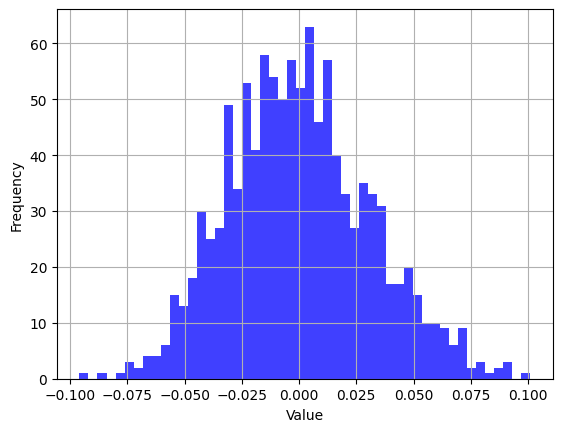

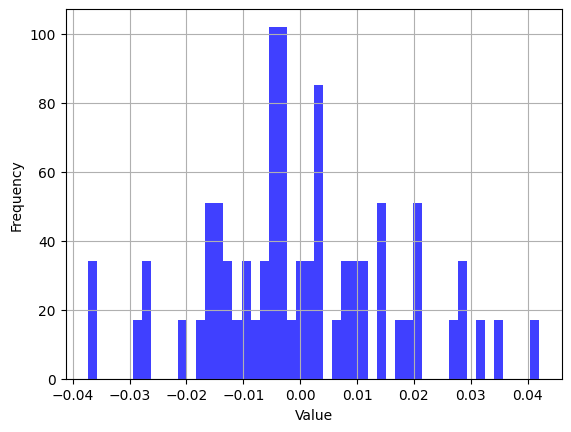

In [21]:
histogram(x)
histogram(x_hat)

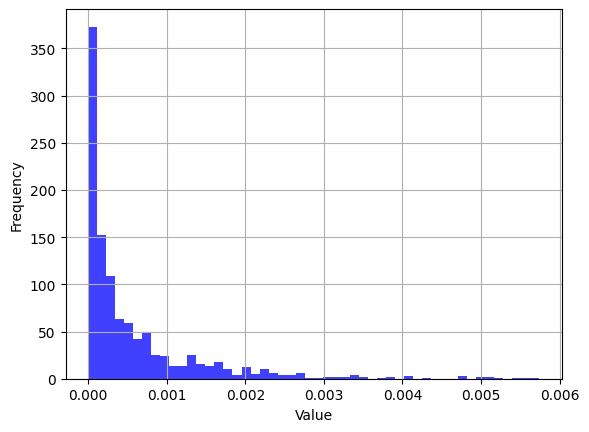

tensor(0.0006)

In [22]:
per_item_mse_loss = F.mse_loss(x, x_hat, reduction="none")
histogram(per_item_mse_loss)
F.mse_loss(x, x_hat)

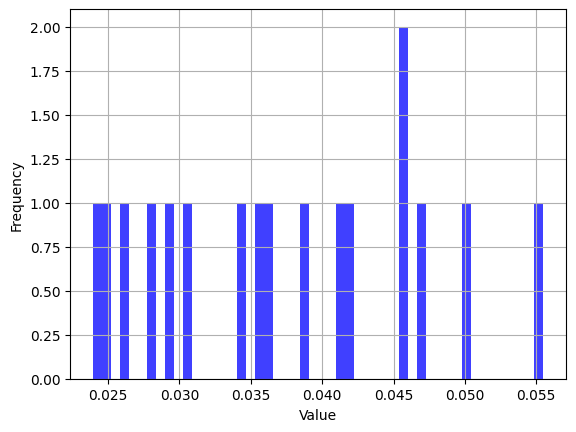

tensor(0.0373)

In [23]:
histogram(per_item_mse_loss.sum(dim=-1))
per_item_mse_loss.sum(dim=-1).mean()

In [24]:
new_state_dict = {
    "W_enc": state_dict["encoder.weight"].T,
    "b_enc": state_dict["encoder.bias"],
    "W_dec": state_dict["decoder.weight"].T,
    "b_dec": state_dict["decoder.bias"],
}

In [25]:
d_hidden, d_in = state_dict["encoder.weight"].shape
cfg = AutoEncoderConfig(d_in=d_in, d_hidden=d_hidden)
encoder = AutoEncoder(cfg)
encoder.load_state_dict(new_state_dict)

for k, v in encoder.named_parameters():
    print(f"{k}: {tuple(v.shape)}")

W_enc: (64, 512)
W_dec: (512, 64)
b_enc: (512,)
b_dec: (64,)


In [26]:
SEQ_LEN = 128

# Load in the data (it's a Dataset object)
data = load_dataset("roneneldan/TinyStories", split="train")
assert isinstance(data, Dataset)

# Tokenize the data (using a utils function) and shuffle it
tokenized_data = utils.tokenize_and_concatenate(data, model.tokenizer, max_length=SEQ_LEN) # type: ignore
tokenized_data = tokenized_data.shuffle(42)

# Get the tokens as a tensor
all_tokens = tokenized_data["tokens"]
assert isinstance(all_tokens, torch.Tensor)

print(all_tokens.shape)

torch.Size([3714797, 128])


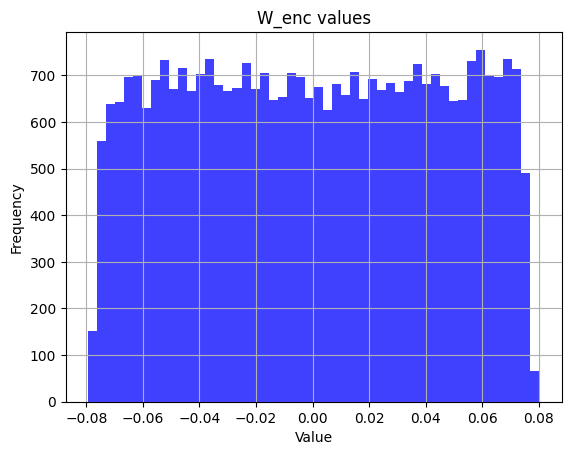

In [27]:
histogram(encoder.W_enc, 'W_enc values')

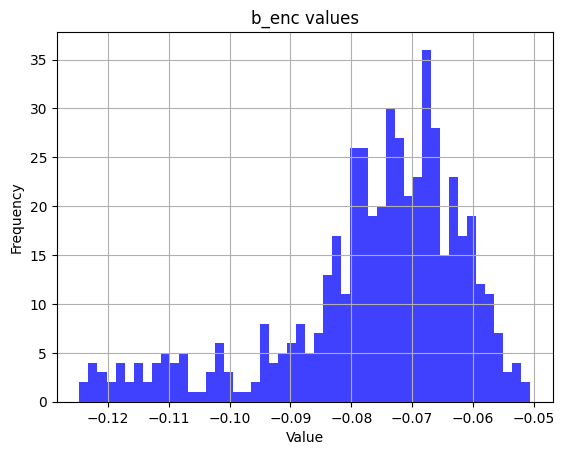

In [28]:
histogram(encoder.b_enc, 'b_enc values')

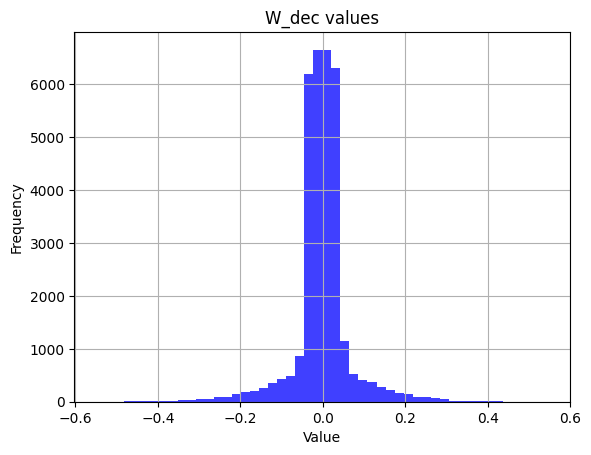

In [29]:
histogram(encoder.W_dec, 'W_dec values')

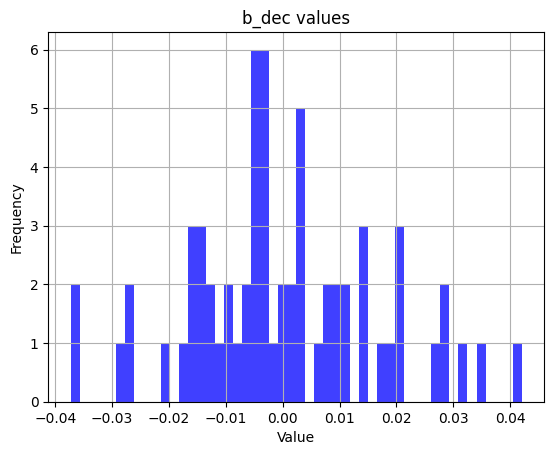

In [30]:
histogram(encoder.b_dec, 'b_dec values')